# Creating a Maze Solver using Pix2Pix

> Maze solving has been a classic computer science problem for decades. Traditionally, we've relied on algorithms like depth-first search, breadth-first search, or A* to find paths through labyrinths. But what if, instead of explicitly programming a solution, we could teach a neural network to visually understand and solve mazes? This is exactly what I set out to explore using a Pix2Pix GAN architecture.

- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- author: Abhishek Sharma
- image: images/pix2pix.png
- categories: [math, deeplearning, gan]

The experiment is simple but powerful: generate a dataset of maze images paired with their solutions, then train a Pix2Pix model to translate from 'unsolved maze' to 'solved maze.' Unlike traditional algorithms that traverse paths step-by-step, this neural network would learn to 'see' the entire solution at once.

## Dataset Generation

I created a custom maze generator using a depth-first search algorithm with backtracking. Each maze was represented as a binary image where black pixels (0) represented walls and white pixels (255) represented paths. Start and end points were marked with distinct grayscale values. For each maze, I also generated the correct solution path using breadth-first search, marking the path with a medium gray color.

In [1]:
# Maze Dataset Generation
# This script generates a dataset of maze images and their solutions
# for training the pix2pix GAN model

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from pathlib import Path
import argparse
import time

# Constants
WALL = 0  # Black
PATH = 255  # White
START = 200  # Light gray
END = 150  # Darker gray
SOLUTION = 100  # Medium gray

In [ ]:
def generate_maze(width, height):
    """Generate a maze using Depth-First Search with backtracking.

    Args:
        width: Width of the maze (in cells)
        height: Height of the maze (in cells)

    Returns:
        A 2D numpy array representing the maze
    """
    # Initialize maze with walls
    maze = np.zeros((height * 2 + 1, width * 2 + 1), dtype=np.uint8)

    # Create a grid to track visited cells
    visited = np.zeros((height, width), dtype=bool)

    # Stack for backtracking
    stack = []

    # Start at a random cell
    x, y = random.randint(0, width - 1), random.randint(0, height - 1)
    visited[y, x] = True
    stack.append((x, y))

    # Possible directions: right, down, left, up
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    # DFS to carve passages
    while stack:
        x, y = stack[-1]

        # Find unvisited neighbors
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                neighbors.append((nx, ny, dx, dy))

        if neighbors:
            # Choose a random neighbor
            nx, ny, dx, dy = random.choice(neighbors)

            # Remove wall between current cell and chosen neighbor
            maze[2*y + 1 + dy, 2*x + 1 + dx] = PATH

            # Mark cell as visited and add to stack
            visited[ny, nx] = True
            maze[2*ny + 1, 2*nx + 1] = PATH
            stack.append((nx, ny))
        else:
            # Backtrack
            stack.pop()

    # Make sure the outer walls are solid
    maze[0, :] = WALL
    maze[-1, :] = WALL
    maze[:, 0] = WALL
    maze[:, -1] = WALL

    # Make all paths white
    maze[maze > 0] = PATH

    return maze


def mark_start_end(maze):
    """Mark start and end points on the maze.

    Args:
        maze: 2D numpy array representing the maze

    Returns:
        The maze with start and end points marked
    """
    # Find all path cells
    path_cells = np.where(maze == PATH)
    path_indices = list(zip(path_cells[0], path_cells[1]))

    # Choose start point (prefer top-left area)
    start_candidates = [p for p in path_indices if p[0] < maze.shape[0]//3 and p[1] < maze.shape[1]//3]
    if not start_candidates:
        start_candidates = path_indices
    start_y, start_x = random.choice(start_candidates)

    # Choose end point (prefer bottom-right area)
    end_candidates = [p for p in path_indices if p[0] > 2*maze.shape[0]//3 and p[1] > 2*maze.shape[1]//3]
    if not end_candidates:
        end_candidates = [p for p in path_indices if p != (start_y, start_x)]
    end_y, end_x = random.choice(end_candidates)

    # Mark start and end
    maze[start_y, start_x] = START
    maze[end_y, end_x] = END

    return maze, (start_y, start_x), (end_y, end_x)


def solve_maze(maze, start, end):
    """Solve the maze using Breadth-First Search.

    Args:
        maze: 2D numpy array representing the maze
        start: (y, x) coordinates of the start point
        end: (y, x) coordinates of the end point

    Returns:
        A copy of the maze with the solution path marked
    """
    # Create a copy of the maze
    solution = maze.copy()

    # Queue for BFS
    queue = [(start, [start])]
    visited = {start}

    # Directions: up, right, down, left
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    while queue:
        (y, x), path = queue.pop(0)

        # Check if we've reached the end
        if (y, x) == end:
            # Mark the solution path
            for py, px in path:
                if (py, px) != start and (py, px) != end:
                    solution[py, px] = SOLUTION
            return solution

        # Try each direction
        for dy, dx in directions:
            ny, nx = y + dy, x + dx

            # Check if the new position is valid
            if (0 <= ny < maze.shape[0] and 0 <= nx < maze.shape[1] and
                maze[ny, nx] != WALL and (ny, nx) not in visited):
                queue.append(((ny, nx), path + [(ny, nx)]))
                visited.add((ny, nx))

    # No solution found
    print("No solution found for the maze!")
    return solution


def create_binary_image(arr, size=256):
    """Convert a numpy array to a binary PIL Image with specified size.

    Args:
        arr: 2D numpy array
        size: Target size for the image

    Returns:
        PIL Image object
    """
    # Create PIL image
    img = Image.fromarray(arr.astype(np.uint8))

    # Resize to target size
    img = img.resize((size, size), Image.NEAREST)

    return img


def generate_dataset(num_mazes, output_dir, size=256, maze_size=(25, 25)):
    """Generate a dataset of mazes and their solutions.

    Args:
        num_mazes: Number of mazes to generate
        output_dir: Directory to save the images
        size: Size of the output images
        maze_size: Size of the maze in cells (width, height)
    """
    # Create output directories
    output_dir = Path(output_dir)
    maze_dir = output_dir / "mazes"
    solution_dir = output_dir / "solutions"

    maze_dir.mkdir(parents=True, exist_ok=True)
    solution_dir.mkdir(parents=True, exist_ok=True)

    for i in range(num_mazes):
        print(f"Generating maze {i+1}/{num_mazes}...")

        # Generate maze
        maze = generate_maze(maze_size[0], maze_size[1])

        # Mark start and end points
        maze, start, end = mark_start_end(maze)

        # Solve maze
        solution = solve_maze(maze, start, end)

        # Create images
        maze_img = create_binary_image(maze, size)
        solution_img = create_binary_image(solution, size)

        # Save images
        maze_img.save(maze_dir / f"maze_{i:04d}.png")
        solution_img.save(solution_dir / f"solution_{i:04d}.png")

    print(f"Dataset generation complete. {num_mazes} mazes created in {output_dir}")


def visualize_maze_pair(maze_path, solution_path):
    """Visualize a maze and its solution side by side."""
    maze_img = Image.open(maze_path)
    solution_img = Image.open(solution_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(maze_img, cmap='gray')
    plt.title("Original Maze")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(solution_img, cmap='gray')
    plt.title("Solution")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def process_existing_dataset(input_dir, output_dir, size=256):
    """Process an existing dataset of mazes to prepare for pix2pix training.

    This function assumes the input directory contains raw maze images,
    and will generate solutions for them.

    Args:
        input_dir: Directory containing maze images
        output_dir: Directory to save processed images
        size: Target size for output images
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    maze_dir = output_dir / "mazes"
    solution_dir = output_dir / "solutions"

    maze_dir.mkdir(parents=True, exist_ok=True)
    solution_dir.mkdir(parents=True, exist_ok=True)

    # Get all maze images
    maze_files = list(input_dir.glob("*.png")) + list(input_dir.glob("*.jpg"))

    for i, maze_file in enumerate(maze_files):
        print(f"Processing maze {i+1}/{len(maze_files)}: {maze_file.name}")

        # Load maze image
        maze_img = Image.open(maze_file).convert('L')  # Convert to grayscale
        maze_img = maze_img.resize((size, size), Image.NEAREST)

        # Convert to numpy array
        maze_array = np.array(maze_img)

        # Threshold to create binary maze (assuming white paths, black walls)
        threshold = 128
        maze_binary = np.zeros_like(maze_array)
        maze_binary[maze_array > threshold] = PATH

        # Try to identify start and end points
        # This is a simplification - you may need a more sophisticated approach
        start = tuple(np.array(np.where(maze_binary == PATH))[:, 0])
        end_y, end_x = np.where(maze_binary == PATH)
        end = (end_y[-1], end_x[-1]) if len(end_y) > 0 else start

        # Mark start and end
        maze_binary[start] = START
        maze_binary[end] = END

        # Solve maze
        solution = solve_maze(maze_binary, start, end)

        # Save processed images
        maze_img = create_binary_image(maze_binary, size)
        solution_img = create_binary_image(solution, size)

        maze_img.save(maze_dir / f"{maze_file.stem}.png")
        solution_img.save(solution_dir / f"{maze_file.stem}.png")

    print(f"Dataset processing complete. {len(maze_files)} mazes processed in {output_dir}")

In [ ]:
def generate_maze(width, height):
    """Generate a maze using Depth-First Search with backtracking.

    Args:
        width: Width of the maze (in cells)
        height: Height of the maze (in cells)

    Returns:
        A 2D numpy array representing the maze
    """
    # Initialize maze with walls
    maze = np.zeros((height * 2 + 1, width * 2 + 1), dtype=np.uint8)

    # Create a grid to track visited cells
    visited = np.zeros((height, width), dtype=bool)

    # Stack for backtracking
    stack = []

    # Start at a random cell
    x, y = random.randint(0, width - 1), random.randint(0, height - 1)
    visited[y, x] = True
    stack.append((x, y))

    # Possible directions: right, down, left, up
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]

    # DFS to carve passages
    while stack:
        x, y = stack[-1]

        # Find unvisited neighbors
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < width and 0 <= ny < height and not visited[ny, nx]:
                neighbors.append((nx, ny, dx, dy))

        if neighbors:
            # Choose a random neighbor
            nx, ny, dx, dy = random.choice(neighbors)

            # Remove wall between current cell and chosen neighbor
            maze[2*y + 1 + dy, 2*x + 1 + dx] = PATH

            # Mark cell as visited and add to stack
            visited[ny, nx] = True
            maze[2*ny + 1, 2*nx + 1] = PATH
            stack.append((nx, ny))
        else:
            # Backtrack
            stack.pop()

    # Make sure the outer walls are solid
    maze[0, :] = WALL
    maze[-1, :] = WALL
    maze[:, 0] = WALL
    maze[:, -1] = WALL

    # Make all paths white
    maze[maze > 0] = PATH

    return maze


def mark_start_end(maze):
    """Mark start and end points on the maze.

    Args:
        maze: 2D numpy array representing the maze

    Returns:
        The maze with start and end points marked
    """
    # Find all path cells
    path_cells = np.where(maze == PATH)
    path_indices = list(zip(path_cells[0], path_cells[1]))

    # Choose start point (prefer top-left area)
    start_candidates = [p for p in path_indices if p[0] < maze.shape[0]//3 and p[1] < maze.shape[1]//3]
    if not start_candidates:
        start_candidates = path_indices
    start_y, start_x = random.choice(start_candidates)

    # Choose end point (prefer bottom-right area)
    end_candidates = [p for p in path_indices if p[0] > 2*maze.shape[0]//3 and p[1] > 2*maze.shape[1]//3]
    if not end_candidates:
        end_candidates = [p for p in path_indices if p != (start_y, start_x)]
    end_y, end_x = random.choice(end_candidates)

    # Mark start and end
    maze[start_y, start_x] = START
    maze[end_y, end_x] = END

    return maze, (start_y, start_x), (end_y, end_x)


def solve_maze(maze, start, end):
    """Solve the maze using Breadth-First Search.

    Args:
        maze: 2D numpy array representing the maze
        start: (y, x) coordinates of the start point
        end: (y, x) coordinates of the end point

    Returns:
        A copy of the maze with the solution path marked
    """
    # Create a copy of the maze
    solution = maze.copy()

    # Queue for BFS
    queue = [(start, [start])]
    visited = {start}

    # Directions: up, right, down, left
    directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]

    while queue:
        (y, x), path = queue.pop(0)

        # Check if we've reached the end
        if (y, x) == end:
            # Mark the solution path
            for py, px in path:
                if (py, px) != start and (py, px) != end:
                    solution[py, px] = SOLUTION
            return solution

        # Try each direction
        for dy, dx in directions:
            ny, nx = y + dy, x + dx

            # Check if the new position is valid
            if (0 <= ny < maze.shape[0] and 0 <= nx < maze.shape[1] and
                maze[ny, nx] != WALL and (ny, nx) not in visited):
                queue.append(((ny, nx), path + [(ny, nx)]))
                visited.add((ny, nx))

    # No solution found
    print("No solution found for the maze!")
    return solution


def create_binary_image(arr, size=256):
    """Convert a numpy array to a binary PIL Image with specified size.

    Args:
        arr: 2D numpy array
        size: Target size for the image

    Returns:
        PIL Image object
    """
    # Create PIL image
    img = Image.fromarray(arr.astype(np.uint8))

    # Resize to target size
    img = img.resize((size, size), Image.NEAREST)

    return img


def generate_dataset(num_mazes, output_dir, size=256, maze_size=(25, 25)):
    """Generate a dataset of mazes and their solutions.

    Args:
        num_mazes: Number of mazes to generate
        output_dir: Directory to save the images
        size: Size of the output images
        maze_size: Size of the maze in cells (width, height)
    """
    # Create output directories
    output_dir = Path(output_dir)
    maze_dir = output_dir / "mazes"
    solution_dir = output_dir / "solutions"

    maze_dir.mkdir(parents=True, exist_ok=True)
    solution_dir.mkdir(parents=True, exist_ok=True)

    for i in range(num_mazes):
        print(f"Generating maze {i+1}/{num_mazes}...")

        # Generate maze
        maze = generate_maze(maze_size[0], maze_size[1])

        # Mark start and end points
        maze, start, end = mark_start_end(maze)

        # Solve maze
        solution = solve_maze(maze, start, end)

        # Create images
        maze_img = create_binary_image(maze, size)
        solution_img = create_binary_image(solution, size)

        # Save images
        maze_img.save(maze_dir / f"maze_{i:04d}.png")
        solution_img.save(solution_dir / f"solution_{i:04d}.png")

    print(f"Dataset generation complete. {num_mazes} mazes created in {output_dir}")


def visualize_maze_pair(maze_path, solution_path):
    """Visualize a maze and its solution side by side."""
    maze_img = Image.open(maze_path)
    solution_img = Image.open(solution_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(maze_img, cmap='gray')
    plt.title("Original Maze")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(solution_img, cmap='gray')
    plt.title("Solution")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def process_existing_dataset(input_dir, output_dir, size=256):
    """Process an existing dataset of mazes to prepare for pix2pix training.

    This function assumes the input directory contains raw maze images,
    and will generate solutions for them.

    Args:
        input_dir: Directory containing maze images
        output_dir: Directory to save processed images
        size: Target size for output images
    """
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    maze_dir = output_dir / "mazes"
    solution_dir = output_dir / "solutions"

    maze_dir.mkdir(parents=True, exist_ok=True)
    solution_dir.mkdir(parents=True, exist_ok=True)

    # Get all maze images
    maze_files = list(input_dir.glob("*.png")) + list(input_dir.glob("*.jpg"))

    for i, maze_file in enumerate(maze_files):
        print(f"Processing maze {i+1}/{len(maze_files)}: {maze_file.name}")

        # Load maze image
        maze_img = Image.open(maze_file).convert('L')  # Convert to grayscale
        maze_img = maze_img.resize((size, size), Image.NEAREST)

        # Convert to numpy array
        maze_array = np.array(maze_img)

        # Threshold to create binary maze (assuming white paths, black walls)
        threshold = 128
        maze_binary = np.zeros_like(maze_array)
        maze_binary[maze_array > threshold] = PATH

        # Try to identify start and end points
        # This is a simplification - you may need a more sophisticated approach
        start = tuple(np.array(np.where(maze_binary == PATH))[:, 0])
        end_y, end_x = np.where(maze_binary == PATH)
        end = (end_y[-1], end_x[-1]) if len(end_y) > 0 else start

        # Mark start and end
        maze_binary[start] = START
        maze_binary[end] = END

        # Solve maze
        solution = solve_maze(maze_binary, start, end)

        # Save processed images
        maze_img = create_binary_image(maze_binary, size)
        solution_img = create_binary_image(solution, size)

        maze_img.save(maze_dir / f"{maze_file.stem}.png")
        solution_img.save(solution_dir / f"{maze_file.stem}.png")

    print(f"Dataset processing complete. {len(maze_files)} mazes processed in {output_dir}")

**Example 5x5 maze**

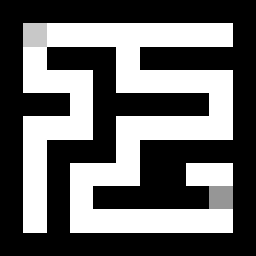

## Pix2Pix Architecture

Pix2Pix is a conditional GAN architecture designed for image-to-image translation tasks. It consists of two main components: a U-Net generator that actually produces the maze solutions, and a PatchGAN discriminator that learns to distinguish between real and fake solutions. The generator takes an unsolved maze as input and attempts to produce its solution, while the discriminator evaluates how realistic these solutions appear compared to the ground truth.

### Training Procedure

I trained the model on two distinct datasets: simpler 5×5 mazes and more complex 10×10 mazes. Each training run involved 50 epochs with a batch size of 8. To balance the different aspects of learning, I used a combination of adversarial loss (to make solutions look realistic) and L1 loss (to ensure accuracy in the solution paths).

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastai.vision.all import *
from fastcore.all import *
from pathlib import Path
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Step 1: Define the U-Net Generator Architecture
class UNetBlock(Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5) if use_dropout else None

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

class UNetUpBlock(Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5) if use_dropout else None

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = self.norm(x)
        x = self.relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = torch.cat([x, skip_connection], dim=1)
        return x

class UNetGenerator(Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        # Initial layer without normalization
        self.initial = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.initial_relu = nn.LeakyReLU(0.2, inplace=True)

        # Downsampling layers
        self.down1 = UNetBlock(64, 128)
        self.down2 = UNetBlock(128, 256)
        self.down3 = UNetBlock(256, 512)
        self.down4 = UNetBlock(512, 512)
        self.down5 = UNetBlock(512, 512)
        self.down6 = UNetBlock(512, 512)
        self.down7 = UNetBlock(512, 512, use_dropout=False)  # No normalization in bottleneck

        # Upsampling layers
        self.up1 = UNetUpBlock(512, 512, use_dropout=True)
        self.up2 = UNetUpBlock(1024, 512, use_dropout=True)
        self.up3 = UNetUpBlock(1024, 512, use_dropout=True)
        self.up4 = UNetUpBlock(1024, 512)
        self.up5 = UNetUpBlock(1024, 256)
        self.up6 = UNetUpBlock(512, 128)
        self.up7 = UNetUpBlock(256, 64)

        # Final layer
        self.final = nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1)
        self.final_activation = nn.Tanh()

    def forward(self, x):
        # Downsampling
        d1 = self.initial_relu(self.initial(x))
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.down7(d7)

        # Upsampling
        u1 = self.up1(bottleneck, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        # Final
        output = self.final(u7)
        output = self.final_activation(output)

        return output


# Step 2: Define the PatchGAN Discriminator
class PatchGANDiscriminator(Module):
    def __init__(self, in_channels=2):  # Input is concatenated maze and solution
        super().__init__()

        self.in_channels = in_channels  # Store in_channels for debugging

        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.final = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, maze, solution):
        # Add debugging to help identify any shape mismatches
        if maze.shape[1] != 1 or solution.shape[1] != 1:
            print(f"Warning: Unexpected channel counts. Maze: {maze.shape}, Solution: {solution.shape}")

        # Concatenate maze and solution along channel dimension
        x = torch.cat([maze, solution], dim=1)

        # Check channel count after concatenation
        if x.shape[1] != self.in_channels:
            print(f"Warning: Channel mismatch. Expected {self.in_channels}, got {x.shape[1]}")

        x = self.initial(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.final(x)
        return x


# Step 3: Create Custom Loss Functions
class GANLoss(Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        else:
            raise NotImplementedError(f'GAN mode {gan_mode} not implemented')

    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        return self.loss(prediction, target_tensor)


# Step 4: Create Pix2Pix Model
class Pix2PixModel(Module):
    def __init__(self, in_channels=1, out_channels=1, lambda_L1=100.0):
        super().__init__()

        self.generator = UNetGenerator(in_channels, out_channels)
        self.discriminator = PatchGANDiscriminator(in_channels + out_channels)

        self.gan_loss = GANLoss('vanilla')
        self.l1_loss = nn.L1Loss()
        self.lambda_L1 = lambda_L1

    def forward(self, maze):
        return self.generator(maze)

    def generator_loss(self, fake_solution, real_solution, fake_pred):
        # Adversarial loss
        g_loss = self.gan_loss(fake_pred, True)
        # L1 loss
        l1_loss = self.l1_loss(fake_solution, real_solution) * self.lambda_L1
        return g_loss + l1_loss, g_loss, l1_loss

    def discriminator_loss(self, real_pred, fake_pred):
        # Real loss
        real_loss = self.gan_loss(real_pred, True)
        # Fake loss
        fake_loss = self.gan_loss(fake_pred, False)
        # Total loss
        return (real_loss + fake_loss) * 0.5


# Step 5: Modified GANTrainer with loss tracking
class GANTrainer(Callback):
    def __init__(self, lambda_L1=100.0, visualize_every=1, save_dir=None):
        super().__init__()
        self.lambda_L1 = lambda_L1
        self.gen_losses = []
        self.disc_losses = []
        self.adv_losses = []
        self.l1_losses = []
        self.epoch_losses = {'g_loss': [], 'd_loss': [], 'g_adv': [], 'g_l1': []}
        self.visualize_every = visualize_every  # Visualize every N epochs
        self.save_dir = save_dir  # Directory to save visualizations

    def before_fit(self):
        # Set up optimizers
        self.gen_opt = torch.optim.Adam(self.model.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.disc_opt = torch.optim.Adam(self.model.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

        # Create save directory if specified
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)

    def before_epoch(self):
        # Reset per-epoch loss trackers
        self.epoch_g_loss = 0.0
        self.epoch_d_loss = 0.0
        self.epoch_g_adv = 0.0
        self.epoch_g_l1 = 0.0
        self.batch_count = 0

    def before_batch(self):
        # Reset gradients (only during training)
        if self.training:
            self.gen_opt.zero_grad()
            self.disc_opt.zero_grad()

    def after_pred(self):
        # Generate fake solutions using generator
        self.learn.pred = self.model.generator(self.xb[0])

    def after_loss(self):
        # Debug input shapes
        maze_shape = self.xb[0].shape
        real_solution_shape = self.yb[0].shape
        fake_solution_shape = self.learn.pred.shape

        # Skip actual training in validation mode
        if not self.training:
            # Just calculate losses for metrics
            with torch.no_grad():
                # Real pairs
                real_pred = self.model.discriminator(self.xb[0], self.yb[0])
                # Fake pairs
                fake_pred = self.model.discriminator(self.xb[0], self.learn.pred)
                # Calculate losses
                disc_loss = self.model.discriminator_loss(real_pred, fake_pred)
                gen_loss, adv_loss, l1_loss = self.model.generator_loss(self.learn.pred, self.yb[0], fake_pred)

                # Store losses for validation metrics
                self.learn.loss = gen_loss
                # No need for loss_grad in validation
                self.learn.loss_grad = None
                self.learn.losses = {
                    'g_loss': gen_loss.item(),
                    'd_loss': disc_loss.item(),
                    'g_adv': adv_loss.item(),
                    'g_l1': l1_loss.item()
                }
            return

        # Training mode - continue with normal training loop
        # Train discriminator first
        self.disc_opt.zero_grad()
        # Detach fake predictions to avoid gradient flow to generator
        fake_sol_detached = self.learn.pred.detach()
        # Real pairs
        real_pred = self.model.discriminator(self.xb[0], self.yb[0])
        # Fake pairs
        fake_pred = self.model.discriminator(self.xb[0], fake_sol_detached)
        # Calculate loss
        disc_loss = self.model.discriminator_loss(real_pred, fake_pred)
        # Backward and update
        disc_loss.backward()
        self.disc_opt.step()

        # Train generator next with a completely fresh computation graph
        self.gen_opt.zero_grad()
        # Generate new fake predictions for G
        fake_sol_for_gen = self.model.generator(self.xb[0])
        # Calculate discriminator output on these new predictions
        fake_pred_for_gen = self.model.discriminator(self.xb[0], fake_sol_for_gen)
        # Calculate generator loss
        gen_loss, adv_loss, l1_loss = self.model.generator_loss(fake_sol_for_gen, self.yb[0], fake_pred_for_gen)
        # Backward and update
        gen_loss.backward()
        self.gen_opt.step()

        # Accumulate losses for epoch average
        self.epoch_g_loss += gen_loss.item()
        self.epoch_d_loss += disc_loss.item()
        self.epoch_g_adv += adv_loss.item()
        self.epoch_g_l1 += l1_loss.item()
        self.batch_count += 1

        # Track individual losses
        self.gen_losses.append(gen_loss.item())
        self.disc_losses.append(disc_loss.item())
        self.adv_losses.append(adv_loss.item())
        self.l1_losses.append(l1_loss.item())

        # Store losses for logging
        self.learn.loss = gen_loss.detach()  # Store detached loss for metrics

        # Create a dummy tensor for fastai's backward pass that requires no gradient
        dummy_loss = torch.tensor(0.0, device=self.xb[0].device, requires_grad=True)
        self.learn.loss_grad = dummy_loss

        # Store other losses for logging
        self.learn.losses = {
            'g_loss': gen_loss.item(),
            'd_loss': disc_loss.item(),
            'g_adv': adv_loss.item(),
            'g_l1': l1_loss.item()
        }

    def after_epoch(self):
        # Calculate average losses for the epoch
        if self.batch_count > 0:
            avg_g_loss = self.epoch_g_loss / self.batch_count
            avg_d_loss = self.epoch_d_loss / self.batch_count
            avg_g_adv = self.epoch_g_adv / self.batch_count
            avg_g_l1 = self.epoch_g_l1 / self.batch_count

            # Store epoch average losses
            self.epoch_losses['g_loss'].append(avg_g_loss)
            self.epoch_losses['d_loss'].append(avg_d_loss)
            self.epoch_losses['g_adv'].append(avg_g_adv)
            self.epoch_losses['g_l1'].append(avg_g_l1)

            print(f"Epoch {self.epoch}: G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}, G_adv: {avg_g_adv:.4f}, G_L1: {avg_g_l1:.4f}")

            # Visualize progress after specified epochs if training
            if self.training and (self.epoch % self.visualize_every == 0 or self.epoch == self.n_epoch-1):
                print(f"Visualizing progress at epoch {self.epoch}...")
                if self.save_dir:
                    show_progress(self.learn, epoch=self.epoch, save_dir=self.save_dir)
                else:
                    show_progress(self.learn, epoch=self.epoch)

    # Override backward to prevent double backpropagation
    def before_backward(self):
        # Skip the actual backward pass since we already did it
        raise CancelBackwardException()

    def plot_losses(self):
        """Plot the loss curves for generator and discriminator."""
        epochs = range(1, len(self.epoch_losses['g_loss']) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(epochs, self.epoch_losses['g_loss'], label='Generator Loss')
        plt.plot(epochs, self.epoch_losses['d_loss'], label='Discriminator Loss')
        plt.title('Generator and Discriminator Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(epochs, self.epoch_losses['g_adv'], label='Adversarial Loss')
        plt.plot(epochs, self.epoch_losses['g_l1'], label='L1 Loss')
        plt.title('Generator Loss Components')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(self.gen_losses, label='Generator')
        plt.title('Generator Loss per Batch')
        plt.xlabel('Batch')
        plt.ylabel('Loss')

        plt.subplot(2, 2, 4)
        plt.plot(self.disc_losses, label='Discriminator')
        plt.title('Discriminator Loss per Batch')
        plt.xlabel('Batch')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.show()


# Function to show progress after each epoch
def show_progress(learner, n=4, epoch=None, save_dir=None):
    """Show original mazes, ground truth solutions, and predicted solutions."""
    # Get a batch from the validation dataloader
    batch = learner.dls.valid.one_batch()
    x, y = batch

    # Only take the first n items
    x = x[:n]
    y = y[:n]

    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))

    for i in range(n):
        # Get maze and solution from batch
        maze = x[i]
        solution = y[i]

        # Original maze - denormalize from [-1,1] to [0,1]
        maze_img = (maze * 0.5 + 0.5).cpu()
        axes[i, 0].imshow(maze_img.permute(1, 2, 0), cmap='gray')
        axes[i, 0].set_title("Original Maze")
        axes[i, 0].axis('off')

        # Ground truth solution - denormalize from [-1,1] to [0,1]
        solution_img = (solution * 0.5 + 0.5).cpu()
        axes[i, 1].imshow(solution_img.permute(1, 2, 0), cmap='gray')
        axes[i, 1].set_title("Ground Truth Solution")
        axes[i, 1].axis('off')

        # Predicted solution
        with torch.no_grad():
            pred_solution = learner.model.generator(maze.unsqueeze(0))[0].cpu()
        # Convert from [-1,1] to [0,1] range
        pred_solution = (pred_solution * 0.5 + 0.5)
        axes[i, 2].imshow(pred_solution.permute(1, 2, 0), cmap='gray')
        axes[i, 2].set_title("Predicted Solution")
        axes[i, 2].axis('off')

    plt.tight_layout()

    # Save the figure if save_dir is provided
    if save_dir is not None and epoch is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(f"{save_dir}/epoch_{epoch:03d}.png")
        plt.close()
    else:
        plt.show()


# Step 6: Modified Pix2PixLearner with progress visualization method
class Pix2PixLearner(Learner):
    def predict(self, maze_img):
        """Generate solution for a single maze image."""
        self.model.eval()
        with torch.no_grad():
            # Convert to tensor and normalize
            if isinstance(maze_img, PILImage):
                tensor_img = PILToTensor(maze_img).float() / 127.5 - 1.0  # Normalize to [-1, 1]
            else:
                tensor_img = maze_img.float() / 127.5 - 1.0

            if len(tensor_img.shape) == 3:  # Add batch dimension if needed
                tensor_img = tensor_img.unsqueeze(0)

            return self.model.generator(tensor_img)

    def visualize_progress(self, n=4):
        """Visualize the current model's performance."""
        show_progress(self, n=n)

    def plot_training_losses(self):
        """Plot the training losses."""
        # Find the GANTrainer callback
        gan_trainer = None
        for cb in self.cbs:
            if isinstance(cb, GANTrainer):
                gan_trainer = cb
                break

        if gan_trainer is not None:
            gan_trainer.plot_losses()
        else:
            print("GANTrainer callback not found.")


# Step 7: Generating or Loading Dataset
def prepare_maze_dataset(maze_dir, solution_dir, size=256):
    """Create Dataset from directories containing maze and solution images."""
    # Print paths for debugging
    print(f"Maze directory: {maze_dir}")
    print(f"Solution directory: {solution_dir}")

    maze_files = get_image_files(maze_dir)
    print(f"Found {len(maze_files)} maze files")

    maze_ids = [f.stem for f in maze_files]

    # Ensure matching solution files exist
    solution_files = [Path(solution_dir)/f"{id_.replace('maze_', 'solution_')}.png" for id_ in maze_ids]
    valid_pairs = [(maze, sol) for maze, sol in zip(maze_files, solution_files) if sol.exists()]

    print(f"Found {len(valid_pairs)} matching maze-solution pairs")

    if len(valid_pairs) < len(maze_files):
        print(f"Warning: Found only {len(valid_pairs)} matching maze-solution pairs out of {len(maze_files)} mazes.")

    # Define transforms to ensure consistent dimensions and normalization
    item_tfms = [Resize(size, method='pad', pad_mode='zeros')]

    # Create DataBlock - explicitly specify that both inputs are grayscale images
    maze_dblock = DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
        get_items=lambda _: valid_pairs,
        get_x=ItemGetter(0),
        get_y=ItemGetter(1),
        item_tfms=item_tfms,
        batch_tfms=[Normalize.from_stats(0.5, 0.5)]
    )

    return maze_dblock


# Step 8: Modified Training Function with improved visualization and tuning options
def train_maze_solver(maze_dir, solution_dir, batch_size=4, num_epochs=50, lr=2e-4, lambda_L1=100.0,
                     save_progress=True, visualize_every=1):
    """Train the maze solver model with detailed progress visualization.

    Args:
        maze_dir: Directory containing maze images
        solution_dir: Directory containing solution images
        batch_size: Batch size for training
        num_epochs: Number of epochs to train
        lr: Learning rate
        lambda_L1: Weight for L1 loss term
        save_progress: Whether to save progress images
        visualize_every: Visualize progress every N epochs
    """
    # Prepare dataset
    maze_dblock = prepare_maze_dataset(maze_dir, solution_dir)
    dls = maze_dblock.dataloaders(Path('.'), bs=batch_size)

    # Log shape information for debugging
    print("Checking batch shapes:")
    try:
        # Try to get one batch
        x, y = dls.one_batch()
        print(f"Input maze batch shape: {x.shape}")
        print(f"Target solution batch shape: {y.shape}")
    except Exception as e:
        print(f"Error getting one batch: {e}")
        # Fallback: try to get first batch from training dataloader
        for x, y in dls.train:
            print(f"Input maze batch shape: {x.shape}")
            print(f"Target solution batch shape: {y.shape}")
            break

    # Create model with correct channel counts based on the data
    model = Pix2PixModel(in_channels=1, out_channels=1, lambda_L1=lambda_L1)

    # Create a directory to save progress images
    progress_dir = "training_progress"
    if save_progress:
        os.makedirs(progress_dir, exist_ok=True)
    else:
        progress_dir = None

    # Create learner with GAN trainer with visualization capability
    learn = Pix2PixLearner(dls, model, loss_func=lambda x, y: torch.tensor(0., device=x.device),
                         cbs=[GANTrainer(lambda_L1=lambda_L1,
                                        visualize_every=visualize_every,
                                        save_dir=progress_dir)])

    # Run learning rate finder before training (optional)
    # learn.lr_find()

    # Train model
    print(f"Starting training with lambda_L1={lambda_L1}, lr={lr}, batch_size={batch_size}...")
    learn.fit_one_cycle(num_epochs, lr)

    # Plot final losses
    learn.plot_training_losses()

    return learn


# Step 9: Visualization Functions
def show_maze_solutions(learner, n=4):
    """Show original mazes, ground truth solutions, and predicted solutions."""
    # Get a batch from the validation dataloader instead of using sample
    batch = learner.dls.valid.one_batch()
    x, y = batch

    # Only take the first n items
    x = x[:n]
    y = y[:n]

    fig, axes = plt.subplots(n, 3, figsize=(12, 4*n))

    for i in range(n):
        # Get maze and solution from batch
        maze = x[i]
        solution = y[i]

        # Original maze - denormalize from [-1,1] to [0,1]
        maze_img = (maze * 0.5 + 0.5).cpu()
        axes[i, 0].imshow(maze_img.permute(1, 2, 0), cmap='gray')
        axes[i, 0].set_title("Original Maze")
        axes[i, 0].axis('off')

        # Ground truth solution - denormalize from [-1,1] to [0,1]
        solution_img = (solution * 0.5 + 0.5).cpu()
        axes[i, 1].imshow(solution_img.permute(1, 2, 0), cmap='gray')
        axes[i, 1].set_title("Ground Truth Solution")
        axes[i, 1].axis('off')

        # Predicted solution
        with torch.no_grad():
            pred_solution = learner.model.generator(maze.unsqueeze(0))[0].cpu()
        # Convert from [-1,1] to [0,1] range
        pred_solution = (pred_solution * 0.5 + 0.5)
        axes[i, 2].imshow(pred_solution.permute(1, 2, 0), cmap='gray')
        axes[i, 2].set_title("Predicted Solution")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# Function to create a grid comparing different hyperparameter settings
def create_comparison_grid(results, base_dir="."):
    """Create a grid visualization comparing the best hyperparameter settings.

    Args:
        results: List of result dictionaries from hyperparameter_search
        base_dir: Base directory where experiment folders are located
    """
    n_results = len(results)
    if n_results == 0:
        return

    # Find the last saved progress images in each experiment directory
    example_images = []
    for result in results:
        dir_path = Path(base_dir) / result['directory']
        image_files = sorted(list(dir_path.glob("epoch_*.png")))
        if image_files:
            example_images.append(str(image_files[-1]))  # Take the last image
        else:
            # If no epoch images found, look for other visualizations
            other_images = list(dir_path.glob("*.png"))
            if other_images:
                example_images.append(str(other_images[0]))
            else:
                example_images.append(None)

    # Create a summary grid
    fig, axes = plt.subplots(n_results, 1, figsize=(15, 5*n_results))
    if n_results == 1:
        axes = [axes]  # Ensure axes is a list for consistency

    for i, (result, img_path) in enumerate(zip(results, example_images)):
        # Add text with hyperparameter info
        title = (f"Rank {i+1}: lambda_L1={result['lambda_L1']}, "
                f"lr={result['lr']}, batch_size={result['batch_size']}\n"
                f"G_loss: {result['final_g_loss']:.4f}, D_loss: {result['final_d_loss']:.4f}")

        axes[i].set_title(title)
        axes[i].axis('off')

        # Display the example image if available
        if img_path and Path(img_path).exists():
            img = plt.imread(img_path)
            axes[i].imshow(img)
        else:
            axes[i].text(0.5, 0.5, "No image available",
                        horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.savefig(f"{base_dir}/hyperparameter_comparison.png")
    plt.close()

In [ ]:
maze_dir     = Path("/kaggle/input/maze-dataset-pix2pix-training/mazes")
solution_dir = Path("/kaggle/input/maze-dataset-pix2pix-training/solutions")

# Train model
learn = train_maze_solver(maze_dir, solution_dir, batch_size=8, num_epochs=50, lr=2e-4, lambda_L1=100)

# Save model
learn.save("maze_solver_model")

# Visualize results
show_maze_solutions(learn, n=4)

### Results and Observations

The results revealed something fascinating about neural network learning capabilities. For simpler 5×5 mazes, the model performed remarkably well, generating solutions nearly indistinguishable from the ground truth. The network learned to identify valid paths and correctly trace routes from start to end.
However, when faced with more complex 10×10 mazes, the model's performance noticeably deteriorated. While it still understood the general concept of path-finding, its solutions became less precise. In several instances, the predicted paths contained discontinuities or slight deviations from the optimal route.

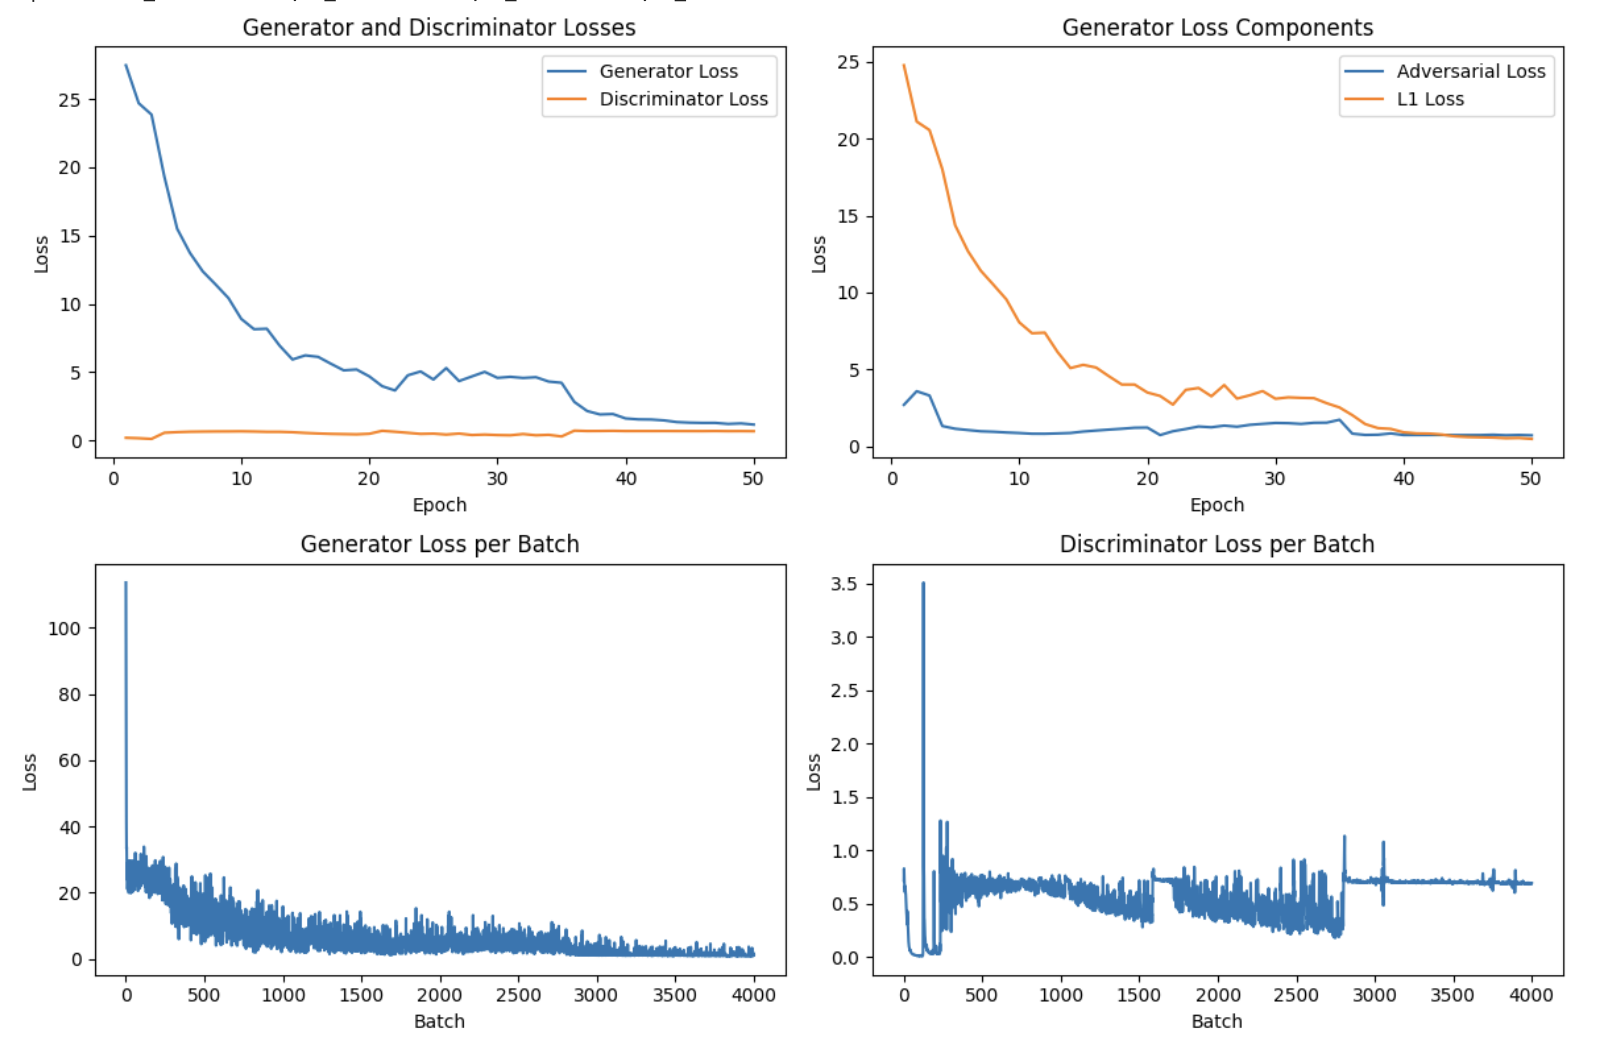

### Analysis and Observations

This performance gap illustrates a fundamental challenge in neural network learning: as the problem space grows, so does the complexity of the required understanding. For larger mazes, the network needs to grasp longer-range dependencies and more complex spatial relationships.
What's particularly interesting is that the network isn't simply failing on larger mazes - it's still identifying major portions of the correct paths. This suggests it has learned generalizable concepts about maze-solving rather than simply memorizing solutions.

**Exmamples of solutions for 5x5 maze**

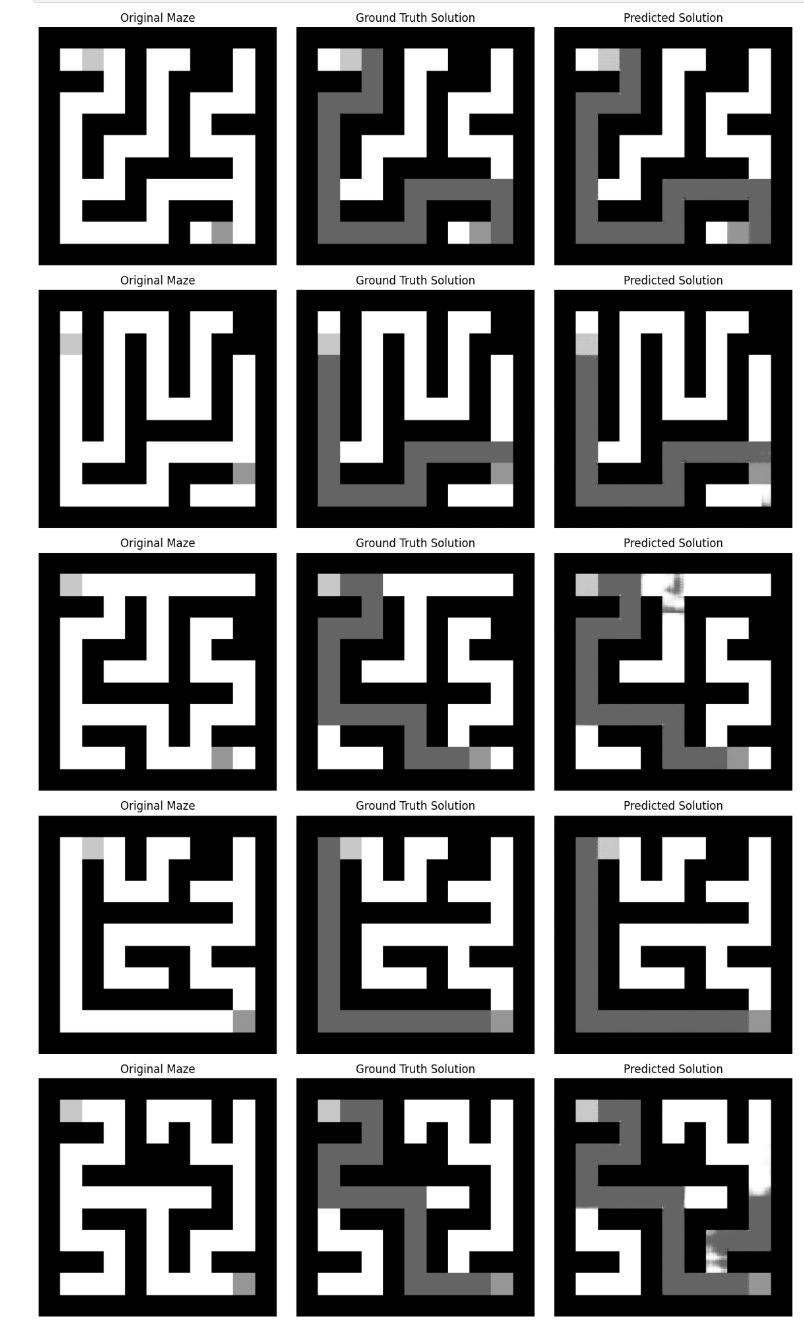

**Examples of solutions for 10x10 maze**

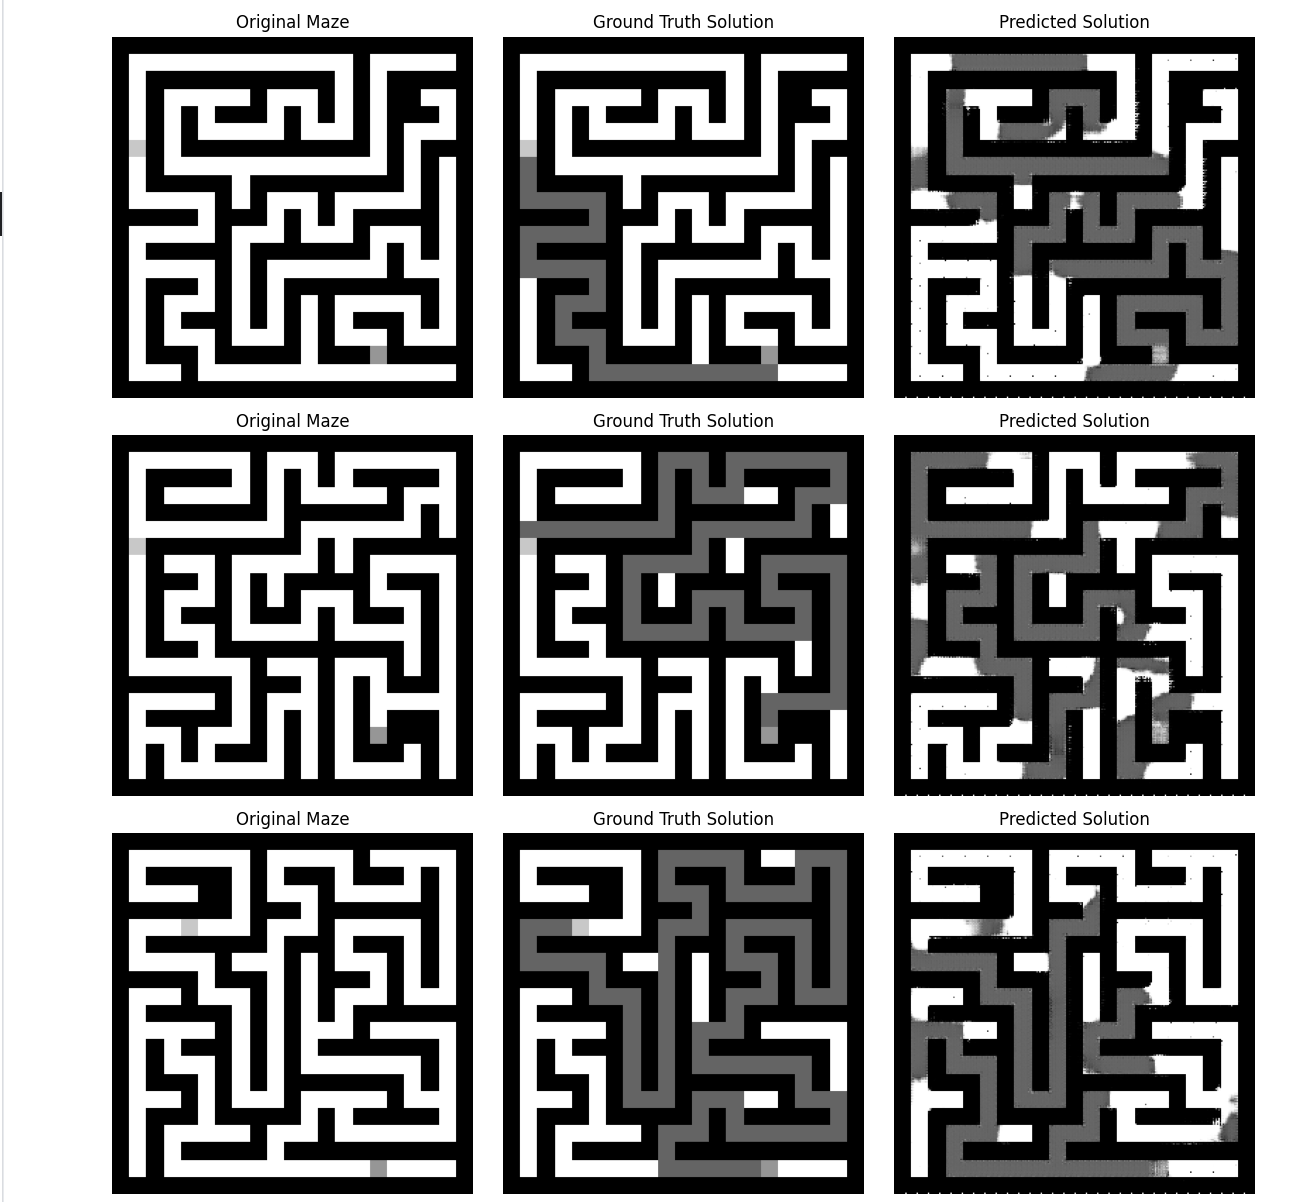

## Future Directions

There are several promising directions to enhance this approach:

- Architecture scaling: Deeper networks with more capacity might better handle complex mazes
- Curriculum learning: Training first on simple mazes, then gradually introducing more complex ones
- Hybrid approaches: Combining neural predictions with traditional pathfinding algorithms.

## References

- https://arxiv.org/abs/1611.07004